In [1]:
%load_ext autoreload
%autoreload 2
import os,sys
# ############################################################
# ### SPECIFIC FOR CUSTOM KERNEL FOR TF1
# ############################################################
sys.path.remove('/opt/xpu/python3.7')
sys.path.remove('/opt/mdsplus/7-92-0/pydevices')
sys.path.append('/theory/clau/.local/share/jupyter/kernels/tf_v1')
# ############################################################
# ############################################################

# add some modules to path
sys.path.append("/theory/clau/python")
sys.path.append("/theory/clau/c2w")
# Add parent directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("/theory/clau/")

# set random seed
RNG_seed = 314159
np.random.seed(RNG_seed)

/theory/clau


In [2]:
from SPIDER_mod.Burgers_Equation import analytical_solution
nu = 0.1 * 5
u_analytical, x, t = analytical_solution(5000, 501, 1.0, 2*np.pi, nu)
noise_level = 1e-1

noise = noise_level * (
    (u_analytical.max()-u_analytical.min()) *
    np.random.randn(u_analytical.shape[0],u_analytical.shape[1])
)
u_noisy = u_analytical + noise

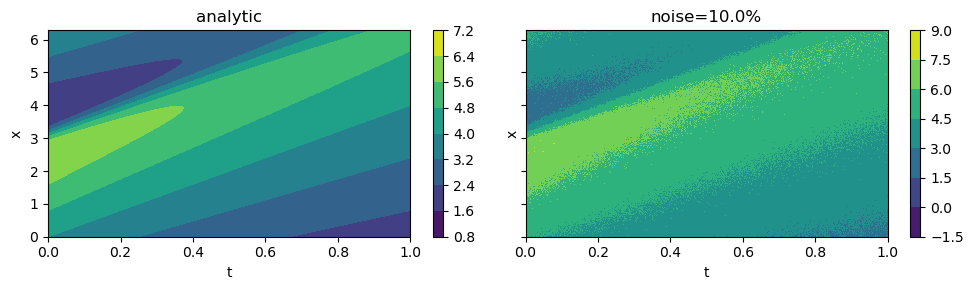

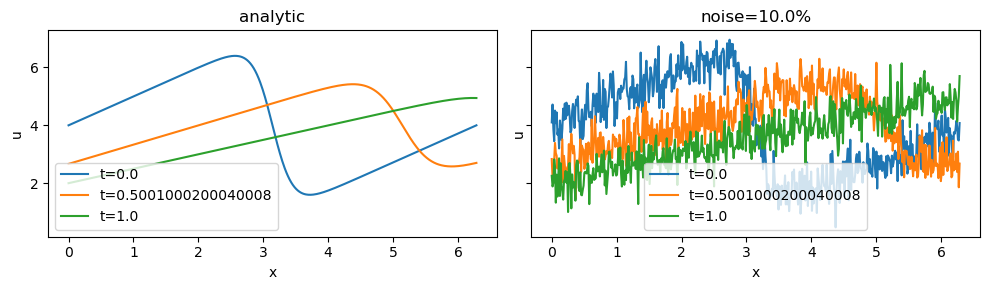

In [3]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, 
    sharex=True, sharey=True,
    figsize=(10,3), dpi=100
)
titles=['analytic', 'noise={}%'.format(noise_level*100)]
for ifig, u in enumerate([u_analytical, u_noisy]):
    cax=axs[ifig].contourf(
        t, x, u
    )
    axs[ifig].set(
        title=titles[ifig],
        xlabel='t', ylabel='x'
    )
    fig.colorbar(cax, ax=axs[ifig])
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(
    nrows=1, ncols=2, 
    sharex=True, sharey=True,
    figsize=(10, 3), dpi=100
)
titles=['analytic', 'noise={}%'.format(noise_level*100)]
for ifig, u in enumerate([u_analytical, u_noisy]):
    for i in [0,len(t)//2,-1]:
        axs[ifig].plot(
            x, u[:,i], label='t={}'.format(t[i])
        )
    axs[ifig].legend()
    axs[ifig].set(
        title=titles[ifig],
        xlabel='x', ylabel='u'
    )
fig.tight_layout()
plt.show()

In [4]:
from SPIDER_mod.sparse_identification_polyfit import sparse_identifier_polyfit
sip = sparse_identifier_polyfit(
    u_noisy, [x, t],
    N_iterations = 10,
    N_terms = [1,2,3,4,5],
    N_samples = 20,
    poly_degree = 3,
    i_pow = 3,
    j_pow = 3,
    i_frac = 0.2,
    j_frac = 0.2,
    RNG_seed = RNG_seed
)
sip.iterate_sparse_identification()

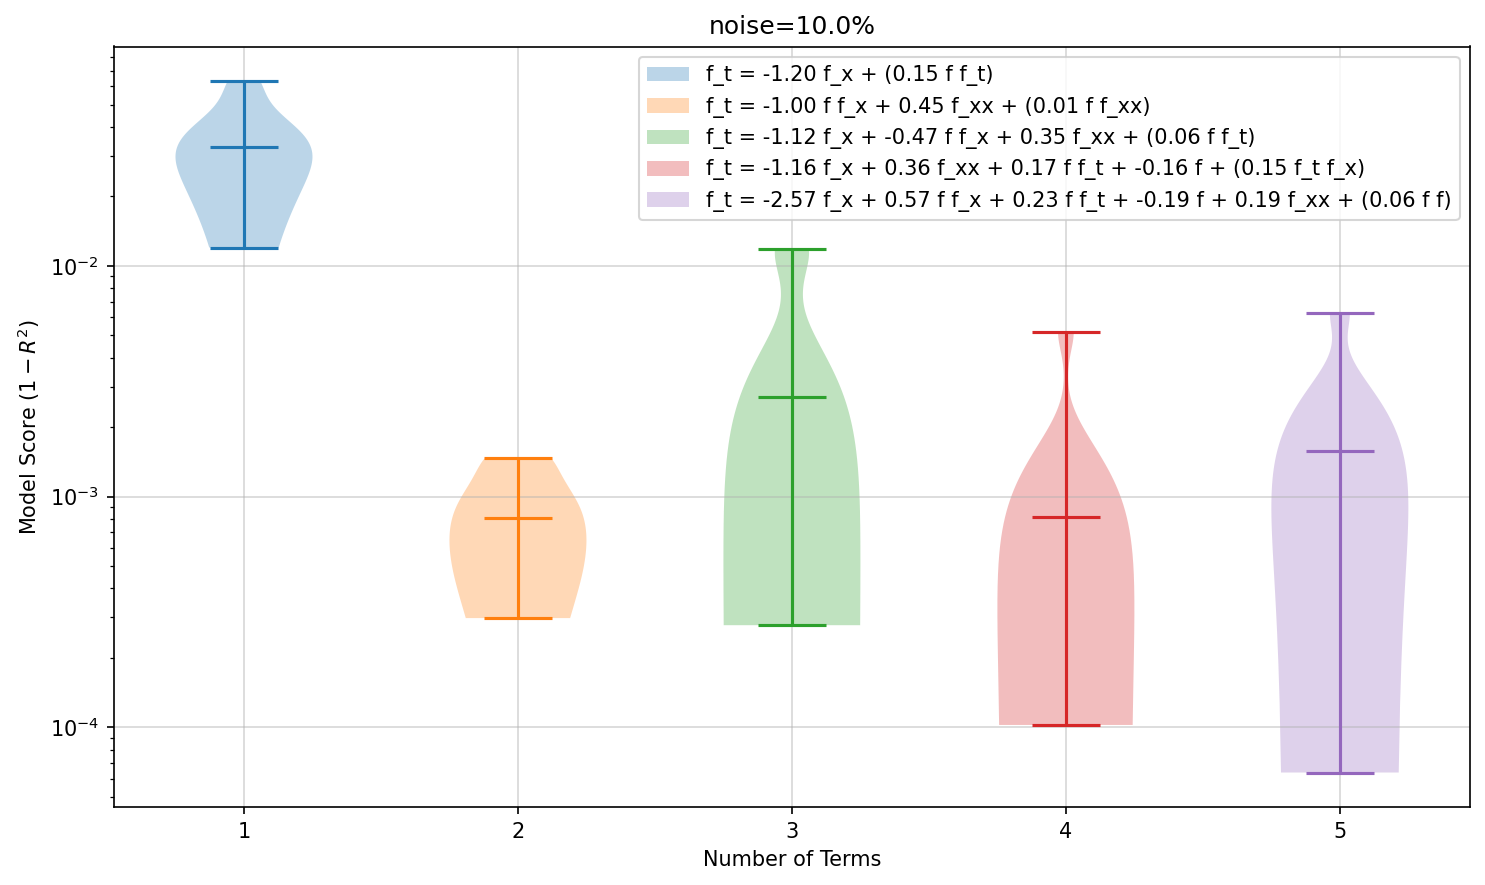

In [5]:
from sparse_identification_polyfit import get_label, get_weighted_average_coefficients

plt.figure(figsize=(5*2,3*2), dpi=150, facecolor='w')

vplots = []; labels = [];
for i, n_term in enumerate(sip.N_terms):
    vp = plt.violinplot(
        1 - sip.scores[:,i],
        positions = [n_term],
        showmeans=True,
        showextrema=True,
        showmedians=False,
        quantiles=None,
    )
    vplots.append(vp)
    labels.append(
        get_label(
            sip.feature_names, 
            get_weighted_average_coefficients(
                sip.coefficients, sip.scores, n_term - 1
            ), 
            threshold=1e-3, 
            N_terms_limit=n_term
        )
    )
vp_handles=[];
for vp in vplots:
    vp_handles.append(vp['bodies'][0])

plt.legend(vp_handles, labels)
plt.yscale('log')
plt.title('noise={:.1f}%'.format(noise_level*100))
plt.xlabel('Number of Terms')
plt.ylabel('Model Score $(1-R^2)$')
# plt.axvline(threshold,c='k',ls='--')
plt.tight_layout()
# plt.ylim(1e-5,1e0)
plt.xticks([1,2,3,4,5])
plt.grid(True, alpha=0.5)
plt.show()